In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
import torch
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



## Intent Dataset

Crisis Detected           50
Help-Seeking & Anxious    50
General Chat & Happy      50
Neutral Intent            50
Name: intent_label, dtype: int64


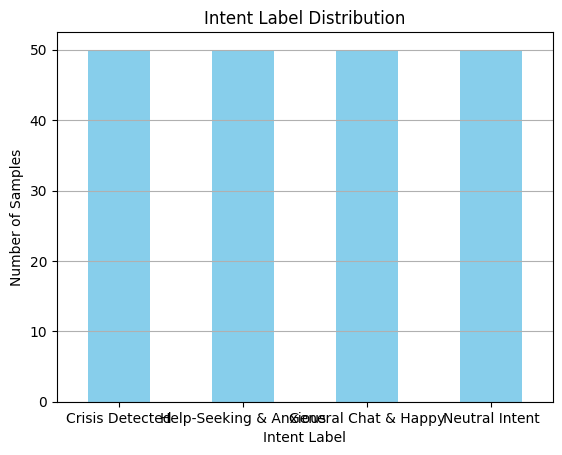

In [3]:

intents_df = pd.read_csv('Intents.csv')
intent_distribution = intents_df['intent_label'].value_counts()

print(intent_distribution)


intent_distribution.plot(kind='bar', color='skyblue')
plt.title('Intent Label Distribution')
plt.xlabel('Intent Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [4]:
# Split intent data explicitly (70-15-15%)
intent_mapping = {'General Chat & Happy': 0, 'Neutral Intent': 1, 'Help-Seeking & Anxious': 2, 'Crisis Detected': 3}
intents_df['intent_label'] = intents_df['intent_label'].map(intent_mapping)

intent_train, intent_temp = train_test_split(intents_df, test_size=0.3, stratify=intents_df['intent_label'], random_state=42)
intent_val, intent_test = train_test_split(intent_temp, test_size=0.5, stratify=intent_temp['intent_label'], random_state=42)


In [5]:
# Explicitly check intent distribution in all splits:
print("Intent distribution in Training Set:")
print(intent_train['intent_label'].value_counts(normalize=True))

print("\nIntent distribution in Validation set:")
print(intent_val['intent_label'].value_counts(normalize=True))

print("\nTest set intent label distribution:")
print(intent_test['intent_label'].value_counts(normalize=True))

Intent distribution in Training Set:
0    0.25
3    0.25
2    0.25
1    0.25
Name: intent_label, dtype: float64

Intent distribution in Validation set:
3    0.266667
1    0.266667
0    0.233333
2    0.233333
Name: intent_label, dtype: float64

Test set intent label distribution:
0    0.266667
2    0.266667
3    0.233333
1    0.233333
Name: intent_label, dtype: float64


In [6]:


# Tokenization
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_data(texts, labels):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128), labels

In [7]:
# Dataset class explicitly defined
class MentalHealthDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [12]:
train_encodings, train_labels = tokenize_data(intent_train['text'].tolist(), intent_train['intent_label'].tolist())
val_encodings, val_labels = tokenize_data(intent_val['text'].tolist(), intent_val['intent_label'].tolist())

train_dataset = MentalHealthDataset(train_encodings, train_labels)
val_dataset = MentalHealthDataset(val_encodings, val_labels)

# BERT fine-tuning explicitly
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)  # Adjust num_labels clearly

training_args = TrainingArguments(
    output_dir='./results_intent',
    num_train_epochs=50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.2959827184677124, 'eval_runtime': 0.221, 'eval_samples_per_second': 135.733, 'eval_steps_per_second': 9.049, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.1939011812210083, 'eval_runtime': 0.2191, 'eval_samples_per_second': 136.924, 'eval_steps_per_second': 9.128, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.097132921218872, 'eval_runtime': 0.2198, 'eval_samples_per_second': 136.483, 'eval_steps_per_second': 9.099, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9724393486976624, 'eval_runtime': 0.224, 'eval_samples_per_second': 133.904, 'eval_steps_per_second': 8.927, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8787140250205994, 'eval_runtime': 0.2197, 'eval_samples_per_second': 136.536, 'eval_steps_per_second': 9.102, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7250762581825256, 'eval_runtime': 0.2198, 'eval_samples_per_second': 136.494, 'eval_steps_per_second': 9.1, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7179973721504211, 'eval_runtime': 0.2206, 'eval_samples_per_second': 135.97, 'eval_steps_per_second': 9.065, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6099087595939636, 'eval_runtime': 0.2206, 'eval_samples_per_second': 136.012, 'eval_steps_per_second': 9.067, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5018690228462219, 'eval_runtime': 0.2184, 'eval_samples_per_second': 137.347, 'eval_steps_per_second': 9.156, 'epoch': 9.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.44010284543037415, 'eval_runtime': 0.2247, 'eval_samples_per_second': 133.531, 'eval_steps_per_second': 8.902, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.36485251784324646, 'eval_runtime': 0.2167, 'eval_samples_per_second': 138.457, 'eval_steps_per_second': 9.23, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.41874656081199646, 'eval_runtime': 0.2225, 'eval_samples_per_second': 134.861, 'eval_steps_per_second': 8.991, 'epoch': 12.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.30139878392219543, 'eval_runtime': 0.2233, 'eval_samples_per_second': 134.319, 'eval_steps_per_second': 8.955, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.28202852606773376, 'eval_runtime': 0.2182, 'eval_samples_per_second': 137.475, 'eval_steps_per_second': 9.165, 'epoch': 14.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2755557894706726, 'eval_runtime': 0.2175, 'eval_samples_per_second': 137.925, 'eval_steps_per_second': 9.195, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.3094770312309265, 'eval_runtime': 0.2234, 'eval_samples_per_second': 134.275, 'eval_steps_per_second': 8.952, 'epoch': 16.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.24679303169250488, 'eval_runtime': 0.2184, 'eval_samples_per_second': 137.389, 'eval_steps_per_second': 9.159, 'epoch': 17.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23974746465682983, 'eval_runtime': 0.2191, 'eval_samples_per_second': 136.899, 'eval_steps_per_second': 9.127, 'epoch': 18.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23764225840568542, 'eval_runtime': 0.22, 'eval_samples_per_second': 136.363, 'eval_steps_per_second': 9.091, 'epoch': 19.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.25614461302757263, 'eval_runtime': 0.2242, 'eval_samples_per_second': 133.83, 'eval_steps_per_second': 8.922, 'epoch': 20.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.24271802604198456, 'eval_runtime': 0.218, 'eval_samples_per_second': 137.591, 'eval_steps_per_second': 9.173, 'epoch': 21.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.1950802505016327, 'eval_runtime': 0.2217, 'eval_samples_per_second': 135.295, 'eval_steps_per_second': 9.02, 'epoch': 22.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.21912604570388794, 'eval_runtime': 0.2207, 'eval_samples_per_second': 135.945, 'eval_steps_per_second': 9.063, 'epoch': 23.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.252519428730011, 'eval_runtime': 0.2195, 'eval_samples_per_second': 136.683, 'eval_steps_per_second': 9.112, 'epoch': 24.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23028521239757538, 'eval_runtime': 0.2161, 'eval_samples_per_second': 138.83, 'eval_steps_per_second': 9.255, 'epoch': 25.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2088124305009842, 'eval_runtime': 0.2215, 'eval_samples_per_second': 135.41, 'eval_steps_per_second': 9.027, 'epoch': 26.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23384663462638855, 'eval_runtime': 0.2194, 'eval_samples_per_second': 136.719, 'eval_steps_per_second': 9.115, 'epoch': 27.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23135215044021606, 'eval_runtime': 0.2214, 'eval_samples_per_second': 135.531, 'eval_steps_per_second': 9.035, 'epoch': 28.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.22879792749881744, 'eval_runtime': 0.2216, 'eval_samples_per_second': 135.405, 'eval_steps_per_second': 9.027, 'epoch': 29.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23304055631160736, 'eval_runtime': 0.2204, 'eval_samples_per_second': 136.096, 'eval_steps_per_second': 9.073, 'epoch': 30.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.22679859399795532, 'eval_runtime': 0.2176, 'eval_samples_per_second': 137.863, 'eval_steps_per_second': 9.191, 'epoch': 31.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.21838903427124023, 'eval_runtime': 0.2204, 'eval_samples_per_second': 136.13, 'eval_steps_per_second': 9.075, 'epoch': 32.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.21635502576828003, 'eval_runtime': 0.2208, 'eval_samples_per_second': 135.873, 'eval_steps_per_second': 9.058, 'epoch': 33.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.22339285910129547, 'eval_runtime': 0.2211, 'eval_samples_per_second': 135.697, 'eval_steps_per_second': 9.046, 'epoch': 34.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2340935915708542, 'eval_runtime': 0.2199, 'eval_samples_per_second': 136.416, 'eval_steps_per_second': 9.094, 'epoch': 35.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.24325567483901978, 'eval_runtime': 0.2206, 'eval_samples_per_second': 136.013, 'eval_steps_per_second': 9.068, 'epoch': 36.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.24436280131340027, 'eval_runtime': 0.2197, 'eval_samples_per_second': 136.575, 'eval_steps_per_second': 9.105, 'epoch': 37.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.24059194326400757, 'eval_runtime': 0.2192, 'eval_samples_per_second': 136.861, 'eval_steps_per_second': 9.124, 'epoch': 38.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23858164250850677, 'eval_runtime': 0.2193, 'eval_samples_per_second': 136.786, 'eval_steps_per_second': 9.119, 'epoch': 39.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23937135934829712, 'eval_runtime': 0.222, 'eval_samples_per_second': 135.151, 'eval_steps_per_second': 9.01, 'epoch': 40.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23217138648033142, 'eval_runtime': 0.2216, 'eval_samples_per_second': 135.405, 'eval_steps_per_second': 9.027, 'epoch': 41.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.22951044142246246, 'eval_runtime': 0.2225, 'eval_samples_per_second': 134.809, 'eval_steps_per_second': 8.987, 'epoch': 42.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.22916531562805176, 'eval_runtime': 0.2174, 'eval_samples_per_second': 137.981, 'eval_steps_per_second': 9.199, 'epoch': 43.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.2304503172636032, 'eval_runtime': 0.2195, 'eval_samples_per_second': 136.688, 'eval_steps_per_second': 9.113, 'epoch': 44.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23165521025657654, 'eval_runtime': 0.2181, 'eval_samples_per_second': 137.543, 'eval_steps_per_second': 9.17, 'epoch': 45.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.233038529753685, 'eval_runtime': 0.2191, 'eval_samples_per_second': 136.927, 'eval_steps_per_second': 9.128, 'epoch': 46.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23148788511753082, 'eval_runtime': 0.2196, 'eval_samples_per_second': 136.621, 'eval_steps_per_second': 9.108, 'epoch': 47.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.231026753783226, 'eval_runtime': 0.2201, 'eval_samples_per_second': 136.291, 'eval_steps_per_second': 9.086, 'epoch': 48.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23098979890346527, 'eval_runtime': 0.2194, 'eval_samples_per_second': 136.749, 'eval_steps_per_second': 9.117, 'epoch': 49.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.23127040266990662, 'eval_runtime': 0.2617, 'eval_samples_per_second': 114.649, 'eval_steps_per_second': 7.643, 'epoch': 50.0}
{'train_runtime': 266.6208, 'train_samples_per_second': 26.255, 'train_steps_per_second': 1.688, 'train_loss': 0.19532511393229166, 'epoch': 50.0}


TrainOutput(global_step=450, training_loss=0.19532511393229166, metrics={'train_runtime': 266.6208, 'train_samples_per_second': 26.255, 'train_steps_per_second': 1.688, 'total_flos': 460452615168000.0, 'train_loss': 0.19532511393229166, 'epoch': 50.0})

In [13]:
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(axis=1)

accuracy = accuracy_score(val_labels, pred_labels)
print(f"Validation accuracy explicitly: {accuracy:.2%}")
print(classification_report(val_labels, pred_labels))

  0%|          | 0/2 [00:00<?, ?it/s]

Validation accuracy explicitly: 90.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.89      1.00      0.94         8
           2       0.75      0.86      0.80         7
           3       1.00      0.75      0.86         8

    accuracy                           0.90        30
   macro avg       0.91      0.90      0.90        30
weighted avg       0.91      0.90      0.90        30



In [14]:
test_encodings, test_labels = tokenize_data(intent_test['text'].tolist(), intent_test['intent_label'].tolist())
test_dataset = MentalHealthDataset(test_encodings, test_labels)
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)

accuracy = accuracy_score(test_labels, pred_labels)
print(f"Test Accuracy explicitly: {accuracy:.2f}")
print(classification_report(test_labels, pred_labels))

  0%|          | 0/2 [00:00<?, ?it/s]

Test Accuracy explicitly: 0.87
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.70      1.00      0.82         7
           2       1.00      0.62      0.77         8
           3       1.00      0.86      0.92         7

    accuracy                           0.87        30
   macro avg       0.90      0.87      0.86        30
weighted avg       0.90      0.87      0.86        30



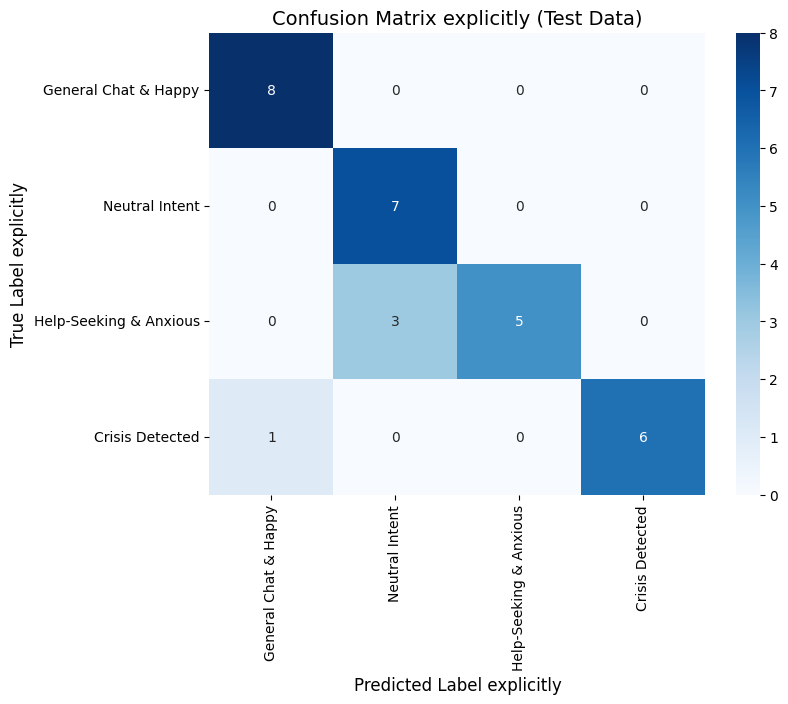

In [15]:
class_labels = ['General Chat & Happy', 'Neutral Intent', 'Help-Seeking & Anxious','Crisis Detected']

cm = confusion_matrix(test_labels, pred_labels)

#  visualize confusion matrix clearly
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

#  label axes clearly
plt.xlabel('Predicted Label explicitly', fontsize=12)
plt.ylabel('True Label explicitly', fontsize=12)
plt.title('Confusion Matrix explicitly (Test Data)', fontsize=14)
plt.show()

In [16]:
model.save_pretrained("./bert_intent_classifier")
tokenizer.save_pretrained("./bert_intent_classifier")

('./bert_intent_classifier/tokenizer_config.json',
 './bert_intent_classifier/special_tokens_map.json',
 './bert_intent_classifier/vocab.txt',
 './bert_intent_classifier/added_tokens.json',
 './bert_intent_classifier/tokenizer.json')

In [21]:
from transformers import BertForSequenceClassification, BertTokenizerFast

# explicitly load the fine-tuned model explicitly
model = BertForSequenceClassification.from_pretrained('./bert_intent_classifier')
tokenizer = BertTokenizerFast.from_pretrained('./bert_intent_classifier')

model.eval()

# explicitly your input clearly
text = "i'm feeling lonely"

# explicitly tokenize input clearly
encoding = tokenizer(text, return_tensors='pt')

# explicitly get model outputs (logits) clearly
with torch.no_grad():  # explicitly disable gradient computation for inference clearly
    output = model(**encoding)

# explicitly predict clearly (get class with highest logit clearly)
predicted_class_id = torch.argmax(output.logits, dim=-1).item()

# explicitly map back clearly to your labels explicitly
id_to_label = {0: 'General Chat & Happy', 1: 'Neutral Intent', 2: 'Help-Seeking & Anxious', 3: 'Crisis Detected'}

predicted_label = id_to_label[predicted_class_id]

# explicitly print prediction clearly
print(f"Predicted Sentiment explicitly: {predicted_label} (Class ID: {predicted_class_id})")


Predicted Sentiment explicitly: Help-Seeking & Anxious (Class ID: 2)
